## 1.Setup

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%autosave 20

import csv
import pandas as pd
from keras.backend import tf as ktf
import sys
import cv2
import six

# keras
import keras
from keras.models import Model
from keras.models import Sequential
from keras.regularizers import l2
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler

from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Dropout
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras import backend as K
import math

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

ROOT_PATH = Path('/home/downloads/CarND-Behavioral-Cloning-P3/')
#ROOT_PATH=Path('/src')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#SAMPLE_DATA_PATH = ROOT_PATH/'data/sample_data'
SAMPLE_DATA_PATH = ROOT_PATH/'data/all'
print('tensorflow version: ', tf.__version__)
print('keras version: ', keras.__version__)
print('python version: ', sys.version_info)

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


Autosaving every 20 seconds


Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9909052066431390624
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5530910720
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17050051167782165594
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:1d:00.0, compute capability: 6.1"
]
tensorflow version:  1.8.0
keras version:  2.2.0
python version:  sys.version_info(major=3, minor=5, micro=5, releaselevel='final', serial=0)


## 2. Load images

This part read all the images I collected for track 1 and 2. I have 17368 images for track 1 and 42464 images for track 2.

In [11]:
#[str(x) for x in list(SAMPLE_DATA_PATH.iterdir())]
logs = pd.DataFrame()
num_tracks = [0, 0]
include_folders = [
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/IMG',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track1_recovery.csv',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track2_drive4.csv',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track2_curve.csv',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track1_sampledata.csv',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track2_drive3.csv',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/backup',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track2_drive5.csv',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track2_reverse.csv',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track2_drive2.csv',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track2_drive1.csv',
    '/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track1_drive.csv'
    ]
for log_file in SAMPLE_DATA_PATH.glob('*.csv'):
    if str(log_file) not in include_folders:
        continue
    one_log = pd.read_csv(log_file)
    num_rows = one_log.shape[0]
    print(log_file, '\t', num_rows)
    if str(log_file).find('track1') != -1:
        num_tracks[0] += num_rows
    else:
        num_tracks[1] += num_rows
    logs = pd.concat([logs, one_log], axis=0)
print('\ntrack 1: ', num_tracks[0])
print('track 2: ', num_tracks[1])
logs.tail()

/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track1_recovery.csv 	 1458
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track2_drive4.csv 	 10252
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track2_curve.csv 	 6617
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track1_sampledata.csv 	 8036
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track2_drive3.csv 	 2039
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track2_drive5.csv 	 3098
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track2_reverse.csv 	 8873
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track2_drive2.csv 	 5465
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track2_drive1.csv 	 6120
/home/downloads/CarND-Behavioral-Cloning-P3/data/all/driving_log_track1_drive.csv 	 7874

track 1:  17368
track 2:  42464


,center,left,right,steering,throttle,brake,speed
7869,project3/track1/drive/IMG/center_2017_02_25_15...,project3/track1/drive/IMG/left_2017_02_25_15_...,project3/track1/drive/IMG/right_2017_02_25_15...,0.0,0.966374,0.0,30.18213
7870,project3/track1/drive/IMG/center_2017_02_25_15...,project3/track1/drive/IMG/left_2017_02_25_15_...,project3/track1/drive/IMG/right_2017_02_25_15...,0.0,0.966374,0.0,30.18215
7871,project3/track1/drive/IMG/center_2017_02_25_15...,project3/track1/drive/IMG/left_2017_02_25_15_...,project3/track1/drive/IMG/right_2017_02_25_15...,0.0,0.966374,0.0,30.18213
7872,project3/track1/drive/IMG/center_2017_02_25_15...,project3/track1/drive/IMG/left_2017_02_25_15_...,project3/track1/drive/IMG/right_2017_02_25_15...,0.0,0.966374,0.0,30.18214
7873,project3/track1/drive/IMG/center_2017_02_25_15...,project3/track1/drive/IMG/left_2017_02_25_15_...,project3/track1/drive/IMG/right_2017_02_25_15...,0.0,0.966374,0.0,30.18214


## 3. Preprocessing and Augmentation

Extract the left, center and right images and correct the labels accordingly.

I split the data into 80/20 randomly: 80% for training and 20% for validation.

In [12]:
IMG_FOLDER_PATH = SAMPLE_DATA_PATH/'IMG'

def get_img_files(img_folder_path):
    image_files = []
    labels = dict()
    correction = 0.2

    for log in logs.iterrows():
        center, left, right, y = log[1][:4]
        for i, img_path in enumerate([center, left, right]):
            img_path = img_path.split('/')[-1].strip()
            abs_img_path = str(img_folder_path/img_path)
            if i == 1:
                y_corrected = y + correction # left
            elif i == 2:
                y_corrected = y - correction # right
            else:
                y_corrected = y

            image_files.append(abs_img_path)
            labels[abs_img_path] = y_corrected

    np.random.shuffle(image_files)
    trn_end_idx = int(len(image_files)*0.8)
    
    train_img_files = image_files[:trn_end_idx]
    val_img_files = image_files[trn_end_idx:]
    
    return train_img_files, val_img_files, labels

In [13]:
TRAIN_IMG_FILES, VAL_IMG_FILES, LABELS = get_img_files(IMG_FOLDER_PATH)

In [14]:
len(TRAIN_IMG_FILES), len(VAL_IMG_FILES), len(LABELS.keys())

(143596, 35900, 179496)

In [21]:
def augment_data(img, y, probs=0.5):
    # flip
    if np.random.rand() > probs:
        img = np.fliplr(img)
        y = -y
    return img, y

## 4. Create data generator for Keras model training

This part creates a data generator to do the followings:
1. resize the image
2. re-shuffle training and validation dataset separate at the beginning of each epoch
3. augment the images during training

The data generator reads in the list of image paths and only load the images picked up in the minibatch during training. 

In [16]:
# adpated from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html
class GeneratorFromFiles(keras.utils.Sequence):
    '''Generate data from list of image files.'''
    
    def __init__(self, list_files, labels, batch_size=64,
                 dim=(160, 320, 3),
                 post_dim=(66, 200, 3),
                 shuffle=True, 
                 data_aug=None,
                 resize=False):
        '''
        Paramters
        ----------
        list_files : a list of absolute path to image files
        labels : a dictionary mapping image files to labels (classes/continous value)
        batch_size : size for each batch
        dim : dimension for input image, height x width x number of channel
        shuffle : whether to shuffle data at each epoch
        '''
        self.dim = dim
        self.post_dim = post_dim if resize else dim
        self.batch_size = batch_size
        self.list_files = list_files
        self.labels = labels
        self.shuffle = shuffle
        self.data_aug = data_aug
        self.resize=resize
        
        self.on_epoch_end()
        
    def __len__(self):
        return int(len(self.list_files) / self.batch_size)
    
    def __getitem__(self, index):
        # generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # find list of files
        list_files_batch = [self.list_files[k] for k in indexes]
        X, ys = self._generate(list_files_batch, self.data_aug)
        
        return X, ys
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_files))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def _generate(self, list_files_batch, data_aug=None):
        X = np.zeros((self.batch_size, ) + self.post_dim)
        ys = np.zeros((self.batch_size))
        
        for i, img_file in enumerate(list_files_batch):
            x = plt.imread(img_file)
            if self.resize:
                x = cv2.resize(x, (self.post_dim[1], self.post_dim[0]))
            y = self.labels[img_file]
            if data_aug is not None:
                x, y = data_aug(x, y)
            X[i, ] = x
            ys[i] = y
        
        return X, ys

Here is an example for resizing and flipping

Original image

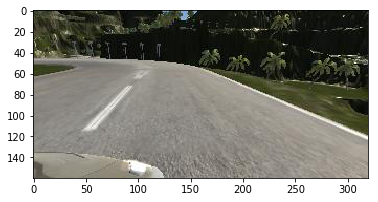

In [17]:
data_generator = GeneratorFromFiles(TRAIN_IMG_FILES, LABELS)
res = next(iter(data_generator))
plt.imshow(res[0][56].astype(int))

After flipping

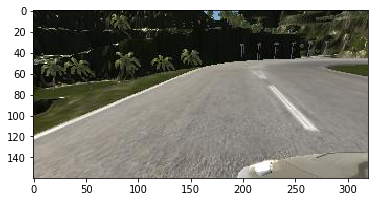

In [18]:
plt.imshow(augment_data(res[0][56], res[1][60], 0.0)[0].astype(int))

After resizing to (66, 200, 3)

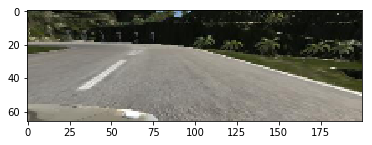

In [30]:
plt.imshow(cv2.resize(res[0][56], (200, 66)).astype(int))

After flipping and resizing

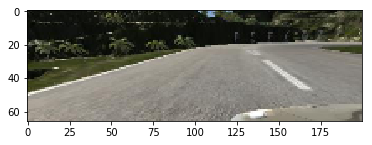

In [34]:
plt.imshow(cv2.resize(augment_data(res[0][56], res[1][60], 0.0)[0], (200, 66)).astype(int))

## 5. Model Architecture and Parameter

### Nvidia model
This part shows the code to create the neural network adapted from Nvidia's paper.
I built a `Conv->Batch Normalization->Activation->Dropout` block and repeated it in the convolutional layers.
I inserted a dropout layer after each fully-connected layer to further reduce the overfitting.

In [1]:
def _bn_act_dropout(input, dropout_rate):
    """Helper to build a BN -> activation block
    """
    norm = BatchNormalization(axis=2)(input)
    relu = Activation('elu')(norm)
    return Dropout(dropout_rate)(relu)
 

def _conv_bn_act_dropout(**conv_params):
    '''Helper to build a conv -> BN -> activation block -> dropout
    '''
    filters = conv_params['filters']
    kernel_size = conv_params['kernel_size']
    strides = conv_params.setdefault('strides', (1, 1))
    kernel_initializer = conv_params.setdefault('kernel_initializer', 'he_normal')
    padding = conv_params.setdefault('padding', 'valid')
    kernel_regularizer = conv_params.setdefault('kernel_regularizer', l2(1.e-4))
    dropout_rate = conv_params.setdefault('dropout_rate', 0.1)

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_act_dropout(conv, dropout_rate)

    return f    

def _dense_dropout(input, n, dropout_rate, dropout_multi=1):
    return Dropout(dropout_rate*dropout_multi)(Dense(n, activation='elu')(input))

def build_nvidia(in_shape, num_outputs, dropout_rate, dropout_multi=1):
    input = Input(shape=in_shape)
    in_layer = Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(in_shape))(input)
    in_layer = _conv_bn_act_dropout(filters=24, kernel_size=(5, 5), strides=(2, 2), dropout_rate=dropout_rate)(in_layer)
    in_layer = _conv_bn_act_dropout(filters=36, kernel_size=(5, 5), strides=(2, 2), dropout_rate=dropout_rate)(in_layer)
    in_layer = _conv_bn_act_dropout(filters=48, kernel_size=(5, 5), strides=(2, 2), dropout_rate=dropout_rate)(in_layer)
    in_layer = _conv_bn_act_dropout(filters=64, kernel_size=(3, 3), strides=(1, 1), dropout_rate=dropout_rate)(in_layer)
    in_layer = _conv_bn_act_dropout(filters=64, kernel_size=(3, 3), strides=(1, 1), dropout_rate=dropout_rate)(in_layer)

    flatten = Flatten()(in_layer)
    flatten = _dense_dropout(flatten, 1000, dropout_rate, dropout_multi)
    flatten = _dense_dropout(flatten, 100, dropout_rate, dropout_multi)
    #flatten = _dense_dropout(flatten, 50, dropout_rate)
    flatten = Dense(50)(flatten)
    dense = Dense(units=num_outputs)(flatten)

    model = Model(inputs=input, outputs=dense)
    return model

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 3
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

Here I define the dropout rate, optimizer and learning rate scheduler

In [13]:
in_shape = (66, 200, 3)
#in_shape = (160, 320, 3)
dropout_rate = 0.2
model = build_nvidia(in_shape, 1, dropout_rate, dropout_multi=2)
opt = Adam(lr=1e-4)
model.compile(loss='mse', optimizer=opt)
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 98, 24)        392       
_________________________________________________________________
activation_1 (Activation)    (None, 31, 98, 24)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 47, 36)        21636     
__________

## 6. Training and Validation

In [15]:
%%time
trn_data_generator = GeneratorFromFiles(TRAIN_IMG_FILES, LABELS, resize=True)
val_data_generator = GeneratorFromFiles(VAL_IMG_FILES, LABELS, resize=True)

model.fit_generator(trn_data_generator, 
                    validation_data=val_data_generator, 
                    epochs=12, 
                    workers=2, 
                    callbacks=callbacks_list,
                    use_multiprocessing=False,
                    verbose=1)

Epoch 1/12
2243/2243 [==============================] - 241s 107ms/step - loss: 0.1739 - val_loss: 0.1210
Epoch 2/12
2243/2243 [==============================] - 238s 106ms/step - loss: 0.1171 - val_loss: 0.0942
Epoch 3/12
2243/2243 [==============================] - 225s 100ms/step - loss: 0.0940 - val_loss: 0.0839
Epoch 4/12
2243/2243 [==============================] - 225s 100ms/step - loss: 0.0851 - val_loss: 0.0869
Epoch 5/12
2243/2243 [==============================] - 226s 101ms/step - loss: 0.0795 - val_loss: 0.0709
Epoch 6/12
2243/2243 [==============================] - 225s 101ms/step - loss: 0.0727 - val_loss: 0.0668
Epoch 7/12
2243/2243 [==============================] - 226s 101ms/step - loss: 0.0707 - val_loss: 0.0686
Epoch 8/12
2243/2243 [==============================] - 225s 100ms/step - loss: 0.0697 - val_loss: 0.0644
Epoch 9/12
2243/2243 [==============================] - 226s 101ms/step - loss: 0.0661 - val_loss: 0.0619
Epoch 10/12
2243/2243 [=======================

In [17]:
# model.load_weights(ROOT_PATH/'models/model-nvidia-base-2.h5')
# trn_data_generator = GeneratorFromFiles(TRAIN_IMG_FILES, LABELS, resize=True)
# val_data_generator = GeneratorFromFiles(VAL_IMG_FILES, LABELS, resize=True)

## 7. Fine-Tuning the Model

In [18]:
%%time
opt = Adam(lr=1e-5)
model.compile(loss='mse', optimizer=opt)
model.fit_generator(trn_data_generator, 
                    validation_data=val_data_generator, 
                    epochs=5, 
                    workers=3, 
                    use_multiprocessing=True,
                    verbose=1)

Epoch 1/5
2243/2243 [==============================] - 180s 80ms/step - loss: 0.0575 - val_loss: 0.0523
Epoch 2/5
2243/2243 [==============================] - 166s 74ms/step - loss: 0.0572 - val_loss: 0.0522
Epoch 3/5
2243/2243 [==============================] - 180s 80ms/step - loss: 0.0571 - val_loss: 0.0524
Epoch 4/5
2243/2243 [==============================] - 179s 80ms/step - loss: 0.0570 - val_loss: 0.0524
Epoch 5/5
2243/2243 [==============================] - 185s 82ms/step - loss: 0.0570 - val_loss: 0.0525
CPU times: user 12min 31s, sys: 5min 37s, total: 18min 9s
Wall time: 14min 50s


## 8. Saving Model

In [23]:
model.save(ROOT_PATH/'models/model-nvidia-base-3.h5', include_optimizer=False)